# Robust nonlinear regression in scipy
TAGS: Optimization and fitting

AUTHORS: Nikolay Mayorov

One of the main applications of nonlinear least squares is nonlinear regression or curve fitting. That is by given pairs $\left\{ (t_i, y_i) \: i = 1, \ldots, n \right\}$ estimate parameters $\mathbf{x}$ defining a nonlinear function $\varphi(t; \mathbf{x})$, assuming the model:
\begin{equation}
y_i = \varphi(t_i; \mathbf{x}) + \epsilon_i
\end{equation}

Where $\epsilon_i$ is the measurement (observation) errors. In the least-squares estimation we search $\mathbf{x}$ as the solution of the following optimization problem:
\begin{equation}
\frac{1}{2} \sum_{i=1}^n (\varphi(t_i; \mathbf{x}) - y_i)^2 \rightarrow \min_\mathbf{x}
\end{equation}

Such formulation is intuitive and convinient from mathematical point of view. From the probabilistic point of view the least-squares solution is known to be the [maximum likelihood](https://en.wikipedia.org/wiki/Maximum_likelihood) estimate, provided that all $\epsilon_i$ are independent and normally distributed random variables.

So theoretically it is not optimal when $\epsilon_i$ have distribution other than normal. Although in engineering practice it is usally not important, i.e. if errors behave as some reasonable random variables with zero mean a result of least-squares estimation will be satisfactory.

The real problems start when data is contaminated by outliers (completly wrong measurements). In this case the least-squares solution can become significantly biased to avoid very high residuals on outliers. To qualitatively explain why it is happening, let's consider the simplest least-squares problem:
\begin{align}
\frac{1}{2} \sum_{i=1}^n (a - x_i)^2 \rightarrow \min_a
\end{align}
And the solution is the mean value:
\begin{align}
a^* = \frac{1}{n} \sum_{i=1}^n x_i
\end{align}

Now imagine: $a = 1, n=4, x_1 = 0.9, x_2 = 1.05, x_3=0.95, x_4=10 \text{ (outlier) }$. The solution $a^* = 3.225$, i.e. completely ruined by a single outlier.

One of the well known robust estimators is l1-estimator, in which the sum of absolute values of the residuals is minimized. For demonstration, again consider the simplest problem:
\begin{equation}
\sum_{i=1}^n |a - x_i| \rightarrow \min_a
\end{equation}

And the well-known solution is the [median](https://en.wikipedia.org/wiki/Median) of $\{x_i\}$, such that the small number of outliers won't affect the solution. In our toy problem we have $a^* = 1$. 

The only disadvantage of l1-estimator is that arising optimization problem is hard, as the function is nondifferentiable everywhere, which is particularly troublesome for efficient nonlinear optimization. It means that we are better to stay with differentiable problems, but somehow incorporate robustness in estimation. To accomplish this we introduce a sublinear function $\rho(z)$ (i.e. its growth should be slower than linear) and formulate a new least-squares-like optimization problem:
\begin{equation}
\frac{1}{2} \sum_{i=1}^n \rho \left((\varphi(t_i; x) - y_i)^2 \right) \rightarrow \min_x
\end{equation}

Turns out that this problem can be reduced to standard nonlinear least squares by modifying a vector of residuals and Jacobian matrix on each iteration, such that computed gradient and Hessian appxoximation match the ones of the objective function. Refer to the [paper](http://link.springer.com/chapter/10.1007%2F3-540-44480-7_21) for details.

The implemented choices of $\rho$ are the following:

1. Linear functior which gives a standard least squares: $\rho(z) = z$.
2. [Huber loss](https://en.wikipedia.org/wiki/Huber_loss): $\rho(z) = \begin{cases} 
z & z \leq 1 \\
\sqrt{z} - 1 & z > 1
\end{cases}$
3. Smooth approximation to absolute value loss, "soft l1 loss": $\rho(z) = 2 (\sqrt{1 + z} - 1)$
4. Cauchy loss: $\rho(z) = \ln(1 + z)$.
5. Loss by arctan: $\rho(z) = \arctan z$.

The functions 2 and 3 are relatively mild and give approximately absolute value loss for large residuals. The last two functions are strongly sublinear and give significant attenuation for outliers.

The loss functions above are written with the assumption that the soft threshold between inliners and outliers is equal to 1.0. To generalize, we introduce the scaling parameter $C$ and evaluate the loss as 
\begin{equation}
\hat{\rho}(r^2) = C^2 \rho \left( \left(\frac{r}{C} \right)^2 \right)
\end{equation}

Note that if residuals are small, we have $\hat{\rho}(r^2) \approx \rho(r^2) \approx r^2$ for any $\rho(z)$ defined above.

To illustrate the behaviour of the introduced functions we build a plot:

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['figure.figsize'] = (10, 6)
rcParams['legend.fontsize'] = 16
rcParams['axes.labelsize'] = 16

In [2]:
r = np.linspace(0, 5, 100)

linear = r**2

huber = r**2
huber[huber > 1] = 2 * r[huber > 1] - 1

soft_l1 = 2 * (np.sqrt(1 + r**2) - 1)

cauchy = np.log1p(r**2)

arctan = np.arctan(r**2)

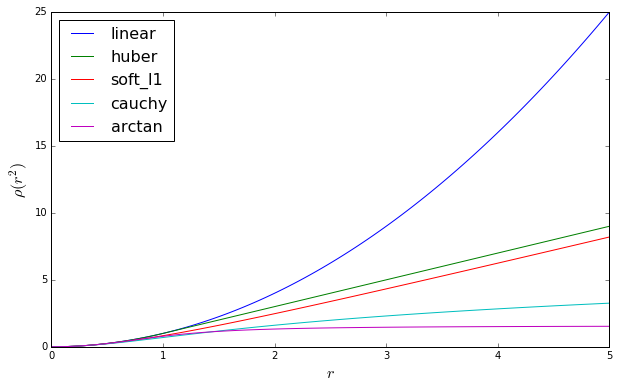

In [3]:
plt.plot(r, linear, label='linear')
plt.plot(r, huber, label='huber')
plt.plot(r, soft_l1, label='soft_l1')
plt.plot(r, cauchy, label='cauchy')
plt.plot(r, arctan, label='arctan')
plt.xlabel("$r$")
plt.ylabel(r"$\rho(r^2)$")
plt.legend(loc='upper left')

-----------------

Now we will show how robust loss functions work on a model example. We define the model function as 
\begin{equation}
f(t; A, \sigma, \omega) = A e^{-\sigma t} \sin (\omega t)
\end{equation}

Which can model a observed displacement of a linear damped oscillator.

Define data generator:

In [4]:
def generate_data(t, A, sigma, omega, noise=0, n_outliers=0, random_state=0):
    y = A * np.exp(-sigma * t) * np.sin(omega * t)
    rnd = np.random.RandomState(random_state)
    error = noise * rnd.randn(t.size)
    outliers = rnd.randint(0, t.size, n_outliers)
    error[outliers] *= 35
    return y + error

Define model parameters:

In [5]:
A = 2
sigma = 0.1
omega = 0.1 * 2 * np.pi
x_true = np.array([A, sigma, omega])

noise = 0.1

t_min = 0
t_max = 30

Data for fitting the parameters will contain 3 outliers:

In [6]:
t_train = np.linspace(t_min, t_max, 30)
y_train = generate_data(t_train, A, sigma, omega, noise=noise, n_outliers=4)

Define the function computing residuals for least-squares minimization:

In [7]:
def fun(x, t, y):
    return x[0] * np.exp(-x[1] * t) * np.sin(x[2] * t) - y

Use all ones as the initial estimate.

In [8]:
x0 = np.ones(3)

In [9]:
from scipy.optimize import least_squares

Run standard least squares:

In [10]:
res_lsq = least_squares(fun, x0, args=(t_train, y_train))

Run robust least squares with `loss='soft_l1'`, set `f_scale` to 0.1 which means that inlier residuals are approximately lower than 0.1.

In [11]:
res_robust = least_squares(fun, x0, loss='soft_l1', f_scale=0.1, args=(t_train, y_train))

Define data to plot full curves.

In [12]:
t_test = np.linspace(t_min, t_max, 300)
y_test = generate_data(t_test, A, sigma, omega)

Compute predictions with found parameters:

In [13]:
y_lsq = generate_data(t_test, *res_lsq.x)
y_robust = generate_data(t_test, *res_robust.x)

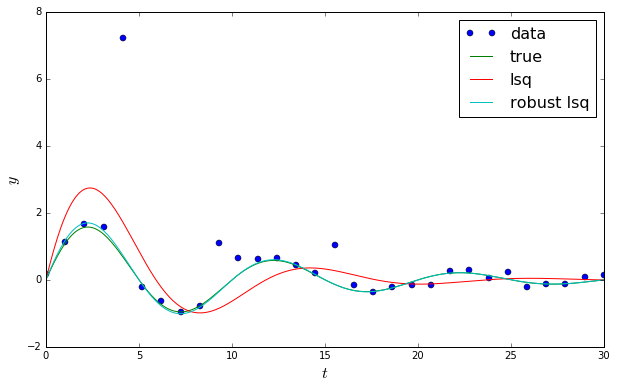

In [14]:
plt.plot(t_train, y_train, 'o', label='data')
plt.plot(t_test, y_test, label='true')
plt.plot(t_test, y_lsq, label='lsq')
plt.plot(t_test, y_robust, label='robust lsq')
plt.xlabel('$t$')
plt.ylabel('$y$')
plt.legend()

We clearly see that standard least squares react significantly on outliers and give very biased solution, whereas robust least squares (with soft l1-loss) give the solution very close to the true model.